In [ ]:
# Download and install libtorch

!wget https://download.pytorch.org/libtorch/cpu/libtorch-cxx11-abi-shared-with-deps-1.9.0%2Bcpu.zip
!unzip libtorch-cxx11-abi-shared-with-deps-1.9.0+cpu.zip


In [ ]:
!pip install ninja

In [1]:
# Download the data

!wget https://cloud.imi.uni-luebeck.de/s/fBnwQNLWXNDqsj5/download -O ct_image_pytorch.pth
!wget https://cloud.imi.uni-luebeck.de/s/nKFxxNoCCpkTpy7/download -O ct_image_jit.pth
!wget https://cloud.imi.uni-luebeck.de/s/kkHziQ8iribHdTG/download -O graph_s_data_jit.pth
!wget https://cloud.imi.uni-luebeck.de/s/snYcKfrr54d53S7/download -O graph_s_data_pytorch.pth


zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget


In [14]:
%%writefile main.cpp

#include <torch/torch.h>
#include <torch/script.h>
#include <iostream>
#include <memory>

using namespace torch::indexing;

namespace F = torch::nn::functional;

torch::Tensor sparseCG(torch::Tensor A, torch::Tensor b, int iterations) {
    b = b.view({-1, 1});
    auto x = torch::zeros_like(b);
    auto r = b.view({-1, 1}) - torch::_sparse_mm(A, x);
    auto p = r.clone();
    for (int i = 0; i < iterations; i++) {
        auto Ap = torch::_sparse_mm(A, p);
        auto top = (r * r).sum();
        auto bottom = (p * Ap).sum();
        auto alpha = top / (bottom + 1e-9);
        x = x + alpha * p;
        r = r - alpha * Ap;
        auto new_top = (r * r).sum();
        auto beta = new_top / (top + 1e-9);
        p = r + beta * p;
    }
    return x;
}


int main() {

    //Exercise 1, Task 1 edge-preserving denoising on regular image grid
    torch::jit::script::Module images = torch::jit::load("ct_image_jit.pth");
    torch::Tensor img = images.attr("img_pytorch").toTensor().squeeze();
    std::cout << "size (img) " << img.size(0) << " x " << img.size(1) << "\n";
    int H = img.size(0); int W = img.size(1);
    float lambda_ = 200; float sigma2 = 0.06*0.06;
    //todo: create range tensor xy0 and sliced tensors xy1 and xy2 and index tensor ii

    //todo: compute edge preserving weights

    //todo: compute first sparse matrix of size H*W,H*W with the wights calculated above

    //todo: flip the direction of the edges and add a second sparse matrix to the initial one

    //todo: create and add sparse matrices by slicing xy in the first dimension

    //todo: use torch::_sparse_sum to compute diagonal elements

    //todo: Create Laplacian matrix L with positive main diagonal elements (plus identity!) and negative weights


    //given: solve equation system
    auto denoised_img = sparseCG(L,img.reshape({-1,1}),150);

    //given: save denoised image
    auto bytes_img = torch::jit::pickle_save(denoised_img.reshape({H,W}));
    std::ofstream fout_img("img_denoise_output.pth", std::ios::out | std::ios::binary);
    fout_img.write(bytes_img.data(), bytes_img.size());
    fout_img.close();

    //Exercise 1, Task 2 denoising on irregular graph
    //given: read tensors from jit.pth file
    torch::jit::script::Module tensors = torch::jit::load("graph_s_data_jit.pth");
    torch::Tensor x = tensors.attr("x").toTensor();
    torch::Tensor y = tensors.attr("y").toTensor();
    torch::Tensor values = tensors.attr("values").toTensor();

    //std::cout << "size (x) " << x.size(0) <<"\n";

    auto xy = torch::stack({x,y},1);
    int n = x.size(0);

    //todo: compute distances of xy-coordinates


    //todo: find the 16th smallest value per row/col using topk and std::get<0>


    //todo: construct laplace matrix (dense is fine)


    //given: solve for denoised values on graph
    auto value_solve = std::get<0>(torch::solve(values.reshape({-1,1}),laplace*25+torch::eye(n)));

    //given: pickle result tensor and write to file
    auto bytes = torch::jit::pickle_save(value_solve.reshape(-1));
    std::ofstream fout("graph_s_output.pth", std::ios::out | std::ios::binary);
    fout.write(bytes.data(), bytes.size());
    fout.close();
}


Overwriting main.cpp


In [ ]:
%%writefile CMakeLists.txt

cmake_minimum_required(VERSION 3.12 FATAL_ERROR)
project(fvmbv_exercise1)

find_package(Torch REQUIRED)
set(CMAKE_CXX_FLAGS "${CMAKE_CXX_FLAGS} ${TORCH_CXX_FLAGS}")

add_executable(fvmbv_exercise1 main.cpp)
target_link_libraries(fvmbv_exercise1 "${TORCH_LIBRARIES}")
set_property(TARGET fvmbv_exercise1 PROPERTY CXX_STANDARD 14)


Overwriting CMakeLists.txt


In [ ]:
%%script bash

mkdir build/
cd build/
cmake ..
make

In [ ]:
import torch
import matplotlib.pyplot as plt


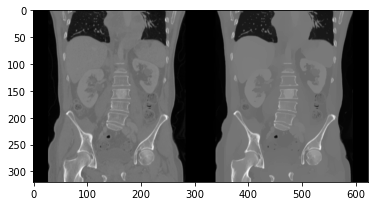

In [ ]:
#Task 1: (pytorch solution framework at the end)
img = torch.load('ct_image_pytorch.pth').squeeze()

img_denoise = torch.load('img_denoise_output.pth')

plt.imshow(torch.cat((img,img_denoise),1),'gray')
plt.show()




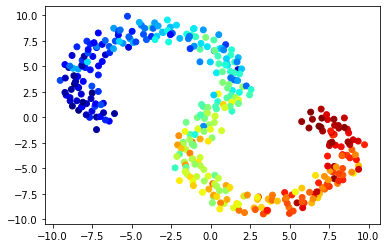

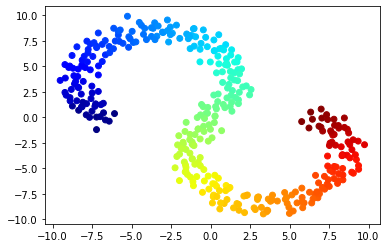

In [ ]:
#Task 2: Denoising on irregular graph (S-shaped 2D points)
xy_value_noise = torch.load('graph_s_data_pytorch.pth')

x = xy_value_noise['x']
y = xy_value_noise['y']
val_noise = xy_value_noise['values']

n = len(val_noise)

cm = plt.cm.get_cmap('jet')
order_noise = torch.zeros(n)
order_noise[torch.sort(val_noise)[1]] = torch.linspace(0,1,n)
plt.scatter(x,y,c=order_noise.numpy(),vmin=0,vmax=1,s=35,cmap=cm)
plt.show()

#read in result from libtorch processing
value_denoise = torch.load('graph_s_output.pth')


order_denoise = torch.zeros(n)
order_denoise[torch.sort(value_denoise)[1]] = torch.linspace(0,1,n)
plt.scatter(x,y,c=order_denoise.numpy(),vmin=0,vmax=1,s=35,cmap=cm)
plt.show()

In [ ]:
def sparseCG(A,b,iterations): #A sparse matrix, b dense vector
#conjugate gradient https://william-dawson.github.io/blog/method/2017/10/01/matrixcg.html
    x = torch.zeros(b.numel(),1).to(A.device)
    r = b.view(-1,1) - torch.spmm(A,x)
    p = r.clone()
    for i in range(iterations):
        Ap = torch.spmm(A,p)
        top = (r*r).sum()
        bottom = (p*Ap).sum()
        alpha = top / (bottom+0.0001)
        x = x + alpha * p
        r = r - alpha * Ap

        #norm_value = torch.norm(r)
        #if norm_value < 1e-8:
        #    break
        new_top = (r*r).sum()
        beta = new_top/(top+0.0001)
        p = r + beta * p
    #print("Done:", i, norm_value)
    return x

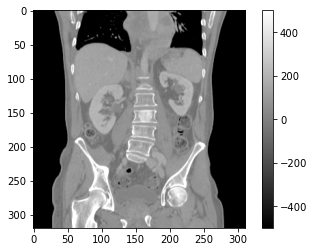

torch.Size([320, 311]) torch.Size([2, 99520])
torch.Size([319, 312]) torch.Size([2, 99528])


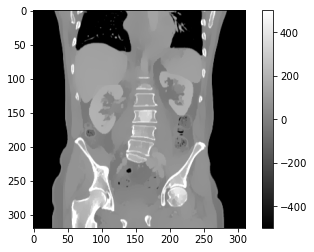

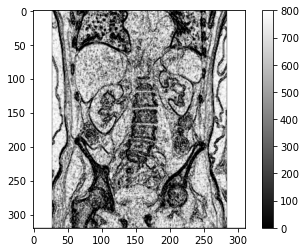

In [ ]:
img = torch.load('ct_image_pytorch.pth').squeeze()

lambda_ = 200
sigma = 0.06#0.08
H,W = img.size()


plt.imshow(torch.clamp(img.reshape(-1,W).data,-500,500),'gray')
plt.colorbar()
plt.show()

# solver equation system
x = sparseCG(L,img.reshape(-1,1),200)

plt.imshow(torch.clamp(x.reshape(-1,W).data,-500,500),'gray')
plt.colorbar()
plt.show()

plt.imshow(torch._sparse_sum(weight,0).to_dense().view(-1,W),'gray')
plt.colorbar()
plt.show()